In [1]:
from DQN_Agent import BuffedDQNAgent, Hyperparams

from trainer import Trainer

/home/qfeuilla/miniconda3/envs/ReinforcmentLearning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
trainer = Trainer(BuffedDQNAgent, Hyperparams())

CONNNNECTING




Mono path[0] = '/home/qfeuilla/Desktop/42ai/ResearchRL/stable_baseline_agent/agent/simulator/build/bomber_Data/Managed'
Mono config path = '/home/qfeuilla/Desktop/42ai/ResearchRL/stable_baseline_agent/agent/simulator/build/bomber_Data/MonoBleedingEdge/etc'
Initialize engine version: 2020.3.26f1 (7298b473bc1a)
[Subsystems] Discovering subsystems at path /home/qfeuilla/Desktop/42ai/ResearchRL/stable_baseline_agent/agent/simulator/build/bomber_Data/UnitySubsystems
Forcing GfxDevice: Null
GfxDevice: creating device client; threaded=0
NullGfxDevice:
    Version:  NULL 1.0 [1.0]
    Renderer: Null Device
    Vendor:   Unity Technologies
Begin MonoManager ReloadAssembly
- Completed reload, in  0.035 seconds
ERROR: Shader Sprites/Default shader is not supported on this GPU (none of subshaders/fallbacks are suitable)
ERROR: Shader Sprites/Mask shader is not supported on this GPU (none of subshaders/fallbacks are suitable)
ERROR: Shader Legacy Shaders/VertexLit shader is not sup

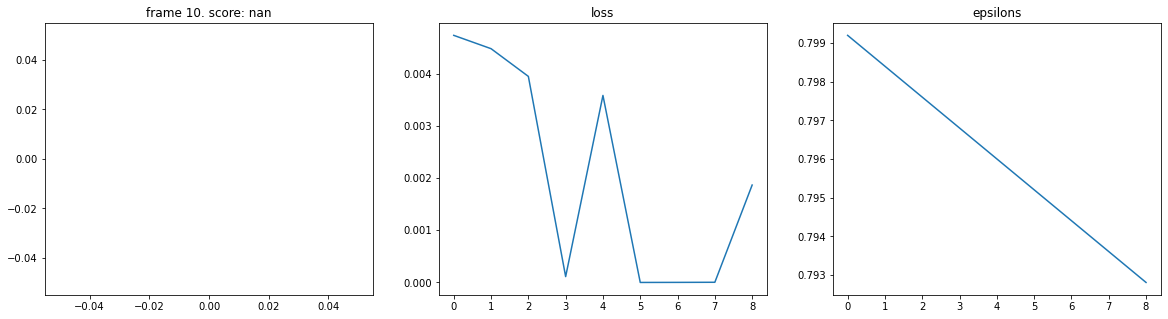

10 steps done
Setting up 12 worker threads for Enlighten.
  Thread -> id: 7f8cb2fe5640 -> priority: 1 
  Thread -> id: 7f8cb27e4640 -> priority: 1 
  Thread -> id: 7f8cb1fe3640 -> priority: 1 
  Thread -> id: 7f8cb17e2640 -> priority: 1 
  Thread -> id: 7f8cb0fe1640 -> priority: 1 
  Thread -> id: 7f8c9ffff640 -> priority: 1 
  Thread -> id: 7f8c9f7fe640 -> priority: 1 
  Thread -> id: 7f8c9effd640 -> priority: 1 
  Thread -> id: 7f8c9e7fc640 -> priority: 1 
  Thread -> id: 7f8c9dffb640 -> priority: 1 
  Thread -> id: 7f8c9d7fa640 -> priority: 1 
  Thread -> id: 7f8c9cff9640 -> priority: 1 


In [3]:
trainer.train()